In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd 
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox
import numpy as np
import networkx as nx
import pyrosm
import contextily as cx 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
ox.__version__

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


'1.1.2'

In [2]:
filename = "lejeboliger_2019_t_april23.csv"

In [3]:
df = pd.read_csv(filename, sep= ";", decimal = ".", dtype={'antal værelser': object, 'lon': float, 'lat': float})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540 entries, 0 to 2539
Data columns (total 96 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   leje                                        2540 non-null   int64  
 1   forudbetalt_leje                            2360 non-null   float64
 2   tilgængelig_fra                             2540 non-null   object 
 3   tilgængelig_til                             5 non-null      object 
 4   max_lejeperiode_måned                       36 non-null     float64
 5   Sagsnr                                      2540 non-null   object 
 6   udbetaling                                  2540 non-null   int64  
 7   realtor_name                                2540 non-null   object 
 8   realtor_zip_code                            2540 non-null   int64  
 9   realtor_road                                2540 non-null   object 
 10  realtor_hous

In [4]:
# Hver leje har et unikt sagsnummer 
columns = ['adresse','created_at','tilgængelig_fra','lon','lat']
duplicates = df['adresse'].duplicated()
duplicates_df = df[duplicates]
duplicates_df[columns].sort_values(by=['adresse'])

,adresse,created_at,tilgængelig_fra,lon,lat
934,"A.C. Meyers Vænge 134, st. th, 2450 København SV",2023-03-13 15:44:39.116639,2023-07-01,12.541444,55.651121
2466,"A.C. Meyers Vænge 134, st. th, 2450 København SV",2023-01-18 15:17:50.427046,2023-02-01,12.541444,55.651121
1623,"A.C. Meyers Vænge 134, st., 2450 København SV",2022-10-19 12:06:24.391324,2022-12-01,12.541444,55.651121
280,"A.C. Meyers Vænge 134, st., 2450 København SV",2022-09-06 18:54:46.890836,2022-12-01,12.541444,55.651121
394,"A.C. Meyers Vænge 4, st. th, 2450 København SV",2023-02-01 13:51:50.113582,2023-05-01,12.543570,55.653152
...,...,...,...,...,...
2149,"Ørestads Boulevard 49B, 7. 4, 2300 København S",2023-03-02 11:48:27.370370,2023-06-01,12.583046,55.636579
1539,"Ørestads Boulevard 49S, 3. 1, 2300 København S",2022-04-25 11:35:38.982118,2022-04-25,12.582915,55.636141
1131,"Ørestads Boulevard 49S, 7. 6, 2300 København S",2022-11-29 12:23:00.718216,2023-01-16,12.582915,55.636141
1880,"Ørestads Boulevard 49T, 4. 3, 2300 København S",2022-10-06 10:37:33.382568,2023-01-15,12.583311,55.636104


In [5]:
# Drop duplicates 
df = df.sort_values('created_at').drop_duplicates('adresse',keep='last')
df[columns].sort_values(by=['adresse'])

,adresse,created_at,tilgængelig_fra,lon,lat
928,"A.C. Meyers Vænge 100, st., 2450 København SV",2022-09-14 18:41:41.516005,2022-12-01,12.542862,55.651663
755,"A.C. Meyers Vænge 112, st., 2450 København SV",2022-08-05 09:25:15.608289,2022-10-01,12.542002,55.651429
1877,"A.C. Meyers Vænge 12, st., 2450 København SV",2023-02-09 08:32:33.489055,2023-05-01,12.543545,55.652971
657,"A.C. Meyers Vænge 120, 2. -3, st., 2450 Københ...",2022-09-06 18:54:46.074245,2023-01-01,12.541266,55.651445
1528,"A.C. Meyers Vænge 120, 3. -2, st., 2450 Københ...",2022-09-05 20:05:13.546010,2022-12-01,12.541266,55.651445
...,...,...,...,...,...
2040,"Ørestads Boulevard 63E, st. th, 2300 København S",2022-04-04 09:35:13.252520,2022-04-27,12.582294,55.632766
1323,"Øresund Parkvej 14, 4. tv, 2300 København S",2022-10-26 11:09:00.289617,2022-12-13,12.629048,55.663250
2101,"Øresundsvej 126B, 2., 2300 København S",2022-10-11 11:25:06.397993,2022-11-04,12.625220,55.661376
2126,"Øresundsvej 138T, 1. tv, 2300 København S",2022-09-12 11:15:38.117696,2022-11-02,12.626060,55.661002


In [6]:
# columns
columns = ["Sagsnr", "tilgængelig_fra", "antal værelser", "boligareal", "leje","per_area_price", "adresse", "zip_code", "lat", "lon"]
df = df[columns]

In [7]:
df2 = df.rename(columns={"tilgængelig_fra": "available_from", "antal værelser": "rooms", "boligareal": "area", "leje": "rent", "adresse": "address", "lon": "longitude", "lat" : "latitude"})
df2.head()

,Sagsnr,available_from,rooms,area,rent,per_area_price,address,zip_code,latitude,longitude
1311,KK-FA076(2521),2023-02-15,5,118.0,17907,455.0,"Richard Mortensens Vej 27L, 2300 København S",2300,55.621580,12.572253
1704,KK-FO021(2521),2022-05-01,2,65.0,11419,527.0,"Richard Mortensens Vej 25A, 4. tv, 2300 Københ...",2300,55.621788,12.572034
2040,199500004381995004,2022-04-27,2,78.0,12000,462.0,"Ørestads Boulevard 63E, st. th, 2300 København S",2300,55.632766,12.582294
509,11802696,2022-06-01,4,142.0,23075,488.0,"Linnésgade 22C, 3. tv, 1361 København K",1361,55.684372,12.571401
2206,11802617,2022-04-15,3,117.0,15500,397.0,"Sundby Parkvej 2, st. th, 2300 København S",2300,55.662417,12.630089


In [8]:
gdf = gpd.GeoDataFrame(
    df2, geometry=gpd.points_from_xy(df.lon, df.lat))

In [9]:
gdf[:10]

,Sagsnr,available_from,rooms,area,rent,per_area_price,address,zip_code,latitude,longitude,geometry
1311,KK-FA076(2521),2023-02-15,5,118.0,17907,455.0,"Richard Mortensens Vej 27L, 2300 København S",2300,55.621580,12.572253,POINT (12.57225 55.62158)
1704,KK-FO021(2521),2022-05-01,2,65.0,11419,527.0,"Richard Mortensens Vej 25A, 4. tv, 2300 Københ...",2300,55.621788,12.572034,POINT (12.57203 55.62179)
2040,199500004381995004,2022-04-27,2,78.0,12000,462.0,"Ørestads Boulevard 63E, st. th, 2300 København S",2300,55.632766,12.582294,POINT (12.58229 55.63277)
509,11802696,2022-06-01,4,142.0,23075,488.0,"Linnésgade 22C, 3. tv, 1361 København K",1361,55.684372,12.571401,POINT (12.57140 55.68437)
2206,11802617,2022-04-15,3,117.0,15500,397.0,"Sundby Parkvej 2, st. th, 2300 København S",2300,55.662417,12.630089,POINT (12.63009 55.66242)
428,11802578,2022-04-01,4,136.0,17500,386.0,"A.C. Meyers Vænge 13D, 1. th, 2450 København SV",2450,55.651306,12.542470,POINT (12.54247 55.65131)
2539,11802610,2021-04-15,2,56.0,11950,640.0,"Andrei Sakharovs Vej 23, 1. th, 2450 København SV",2450,55.656439,12.560252,POINT (12.56025 55.65644)
2078,11802662,2022-03-01,4,131.0,19995,458.0,"Ved Stigbordene 19, 4. th, 2450 København SV",2450,55.644669,12.548321,POINT (12.54832 55.64467)
2496,10-X00017473426001,2022-10-15,3,80.0,12200,458.0,"Else Alfelts Vej 35, 4. 3, 2300 København S",2300,55.620872,12.569423,POINT (12.56942 55.62087)
1431,10-X00017023426001,2022-10-15,3,89.0,12700,428.0,"Richard Mortensens Vej 40, 4. 1, 2300 København S",2300,55.620700,12.570844,POINT (12.57084 55.62070)


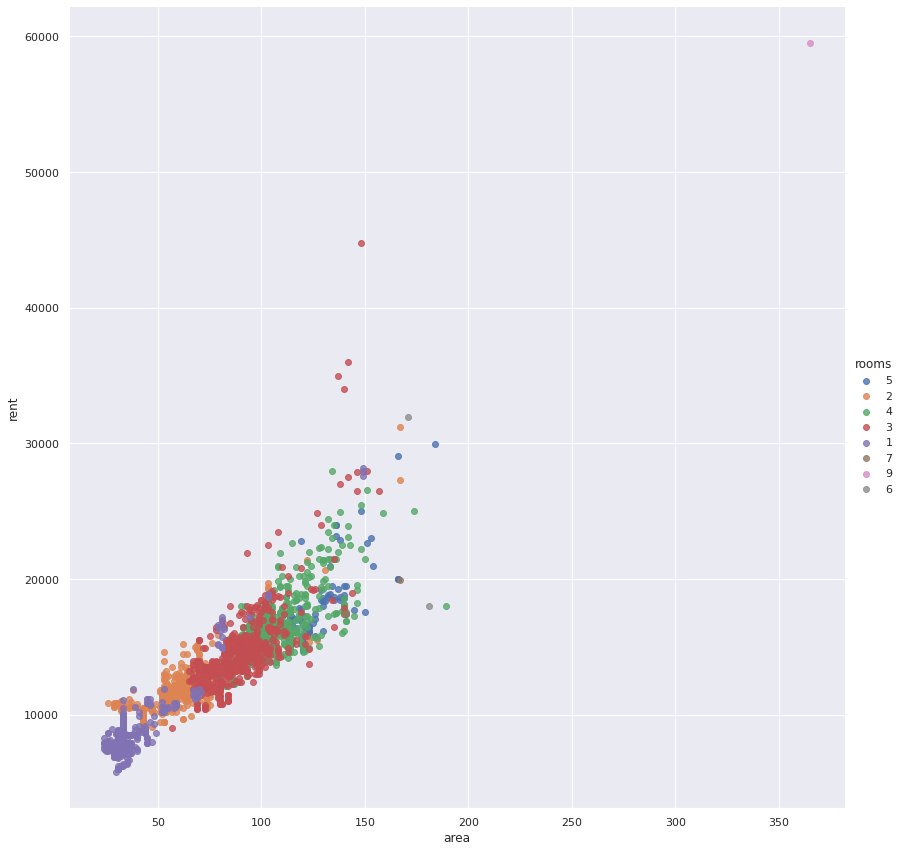

In [10]:
# Plotting 

import seaborn as sns

sns.set(rc={'figure.figsize':(26,12)})
sns.lmplot('area', 'rent', data=df2, hue='rooms', fit_reg=False, height=12, aspect=1)

plt.show()

In [11]:
#geometry = gdp.points_from_xy(df2.longitude, df2.latitude, crs="EPSG:4326")
gdf = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.longitude,df2.latitude, crs="EPSG:4326")).set_index("Sagsnr");

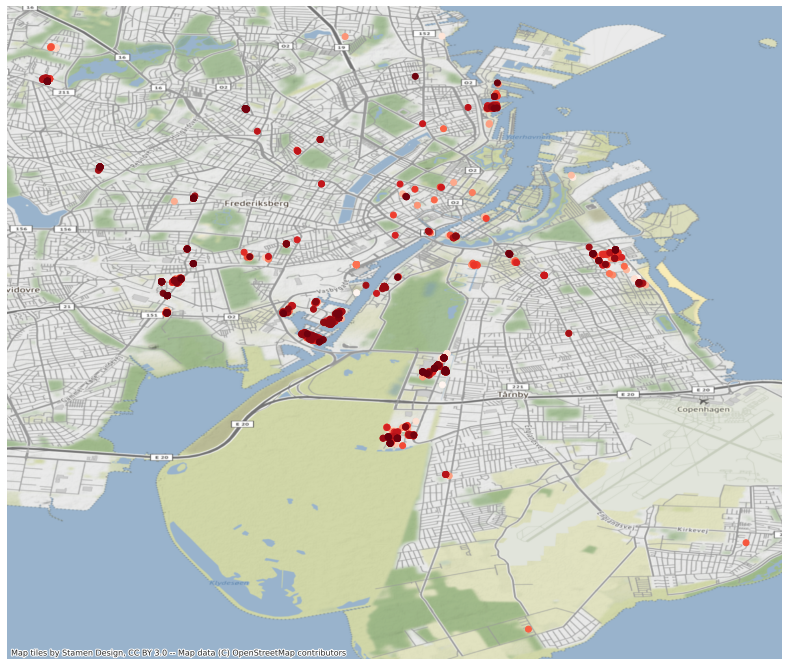

In [12]:
ax = gdf.plot(c=gdf["per_area_price"], cmap='Reds', legend=True) #color="black")
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf.crs)

cmap = plt.cm.get_cmap('cool')
cmap.set_under('red')

Distance to the metro


In [13]:
# Get all the public transport stops    
tags = {'station':'subway','network':'metro'}
transit = ox.geometries_from_place(['Frederiksberg Municipality','Copenhagen Municipality'], tags=tags)

transit = transit.drop_duplicates('name') # avoid duplicates, e.g. when each level/platform of a station is tagged separately

transit = transit.to_crs('EPSG:4326')

transit.head()

name network public_transport  railway  \
element_type osmid                                                              
node         1271230723           Lindevang   Metro          station  station   
             1724493427  Frederiksberg Allé   Metro    stop_position     stop   
             2042342677          Vestamager   Metro          station  station   
             2089115303             Ørestad   Metro          station  station   
             2705309629             Femøren   Metro          station  station   

                        station subway wheelchair wikidata  \
element_type osmid                                           
node         1271230723  subway    yes        yes  Q801103   
             1724493427  subway    yes        NaN      NaN   
             2042342677  subway    yes        yes  Q801562   
             2089115303  subway    yes        yes      NaN   
             2705309629  subway    yes        yes  Q800748   

                                          geometry layer  ... official_name  \
element_type osmid                                        ...                 
node         1271230723  POINT (12.51319 55.68345)   NaN  ...           NaN   
             1724493427  POINT (12.54053 55.67349)   NaN  ...           NaN   
             2042342677  POINT (12.57558 55.61937)     1  ...           NaN   
             2089115303  POINT (12.57935 55.62901)   NaN  ...           NaN   
             2705309629  POINT (12.63834 55.64519)     1  ...           NaN   

                        reg_name short_name train loc_name name:ja name:ko  \
element_type osmid                                                           
node         1271230723      NaN        NaN   NaN      NaN     NaN     NaN   
             1724493427      NaN        NaN   NaN      NaN     NaN     NaN   
             2042342677      NaN        NaN   NaN      NaN     NaN     NaN   
             2089115303      NaN        NaN   NaN      NaN     NaN     NaN   
             2705309629      NaN        NaN   NaN      NaN     NaN     NaN   

                         ref ref_name operator  
element_type osmid                              
node         1271230723  NaN      NaN      NaN  
             1724493427  NaN      NaN      NaN  
             2042342677  NaN      NaN      NaN  
             2089115303  NaN      NaN      NaN  
             2705309629  NaN      NaN      NaN  

[5 rows x 28 columns]

In [14]:
transit = transit.set_index('name')[['geometry']]
transit.head()

,geometry
name,
Lindevang,POINT (12.51319 55.68345)
Frederiksberg Allé,POINT (12.54053 55.67349)
Vestamager,POINT (12.57558 55.61937)
Ørestad,POINT (12.57935 55.62901)
Femøren,POINT (12.63834 55.64519)


In [15]:
transit.count()

geometry    42
dtype: int64

In [16]:
# Get walking network of Copenhagen
G_walk = ox.graph_from_place(['Frederiksberg Municipality','Copenhagen Municipality'], network_type='walk', retain_all=False)

/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/conda/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [17]:
# make into graph
G_walk_proj = ox.project_graph(G_walk, to_crs='EPSG:4326')

In [18]:
nodes = ox.graph_to_gdfs(G_walk_proj, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(G_walk_proj, nodes=False).reset_index()

In [19]:
edges['length'] = edges.length
edges = edges[['u','v','length']]

/tmp/ipykernel_893/3792452601.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edges['length'] = edges.length


In [20]:
# create panadana network 
import pandana
network = pandana.Network(node_x=nodes['x'],
                          node_y=nodes['y'], 
                          edge_from=edges['u'],
                          edge_to=edges['v'],
                          edge_weights=edges[['length']]) 

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 41914
Setting CH edge vector of size 115994
Range graph removed 117504 edges of 231988
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [21]:
# set the locations on the network 
network.set_pois(category='metro',
                 maxdist=3000, # Max distance we will bike
                 maxitems=1, # we are just looking for the one closest station
                 x_col=transit.geometry.x, 
                 y_col=transit.geometry.y)

/opt/conda/lib/python3.9/site-packages/pandana/network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/opt/conda/lib/python3.9/site-packages/pandana/network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


In [22]:
# calculate distance to nearest metro station from each node in network
distances = network.nearest_pois(distance=3000,
                                 category='metro',
                                 num_pois=1,
                                include_poi_ids=True)
distances.sort_values(by=[1])

,1,poi1
osmid,,
6832312039,0.000,Frederiksberg
9704717408,0.000,Ørestad
5697186705,0.000,Lergravsparken
10657723420,0.000,Østerport
10683738399,0.000,Nørreport
...,...,...
2611016713,0.089,Vanløse
5764144568,0.089,Vanløse
5764144577,0.089,Vanløse


/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/opt/conda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are depreca

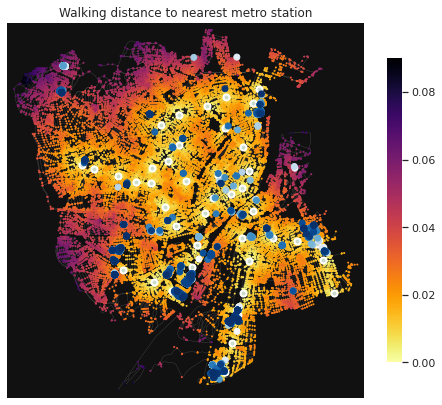

In [23]:
# Plot distance to nearest metro station from each node
fig, ax = ox.plot_graph(G_walk_proj, node_size=0, edge_linewidth=0.1,
                        edge_color='gray', show=False, close=False)

sc = ax.scatter(x=nodes['x'],
                y=nodes['y'], 
                c=distances[1],
                s=1,
                cmap='inferno_r')

# plot stations to sanity check our computations
transit.plot(ax=ax, color='#CBDCCB', edgecolor='white', linewidth=2)
gdf.plot(ax=ax, c=gdf["per_area_price"], cmap='Blues', legend=True) 

ax.set_title('Walking distance to nearest metro station')
plt.colorbar(sc, shrink=0.7).outline.set_edgecolor('none')

# Shortest Distance To Metro
There are different ways to calculate distances between points in a geospatial dataset. The simplest way is to compute the shortest path between any two points using pytagoras. However this will not be true distance since the earths sphere is not considered in the computation. Thus a more true distance can be calculated using the haversine formular. This finds the great-circle distance between any two locations on a sphere using their longitudes and latitudes.

https://pypi.org/project/haversine/


In [24]:
import geopy.distance
from haversine import haversine, Unit
# print(tuple(Unit))

In [69]:
metro_points = transit['geometry']
rental_points = gdf['geometry']

In [41]:
# shortest path 
test_geopy_dist = geopy.distance.distance(rental_points[0].coords[0], metro_points[0].coords[0]).meters

# calculates dist considering the earths sphere
test_geopy = geopy.distance.great_circle(rental_points[0].coords[0], metro_points[0].coords[0]).meters
test_haversine = haversine(rental_points[0].coords[0], metro_points[0].coords[0], unit = Unit.METERS)
print('haversine formular: ', test_geopy, test_haversine, 'shortest dist: ', test_geopy_dist)

haversine formular:  9393.278451625372 9393.278156749857 shortest dist:  9375.980412714287


In [80]:
# Try with geopy distance 

list_of_series = []


for i in range(len(metro_points)):
    dist = rental_points.apply(lambda p: geopy.distance.great_circle(p.coords[0], metro_points[i].coords[0]).meters)
    list_of_series.append(dist)
   
    
distance_df = pd.DataFrame(list_of_series, index = metro_points.index).T
#  pandas.DataFrame(data=None, index=None, columns=None, dtype=None, copy=None)[source]

In [81]:
distance_df

name,Lindevang,Frederiksberg Allé,Vestamager,Ørestad,Femøren,Amager Strand,Bella Center,Øresund,DR Byen,Sundby,...,Nørrebro,Aksel Møllers Have,Nuuks Plads,Skjolds Plads,Vibenhus Runddel,Østerport,Marmorkirken,Trianglen,Poul Henningsens Plads,Nordhavn
Sagsnr,,,,,,,,,,,,,,,,,,,,,
KK-FA076(2521),9393.278452,6646.727219,441.221809,1128.897082,7782.117188,7615.101058,2147.648337,7624.423442,4152.281068,2973.435974,...,9330.853678,8250.274224,7977.645364,9266.564988,9242.561941,7885.613359,7144.241425,8437.540130,9548.874908,9560.857933
KK-FO021(2521),9360.060481,6614.617554,474.007809,1130.247692,7797.721097,7625.220479,2142.491041,7631.708994,4143.110443,2966.317951,...,9300.247801,8218.172659,7946.958903,9237.995379,9217.851816,7868.146934,7128.810858,8416.022133,9527.396263,9544.314565
199500004381995004,9450.506171,6410.478923,1634.010694,522.220234,6375.959526,6066.770460,580.170747,6027.409424,2605.799664,1407.412220,...,8809.914300,7972.074060,7490.744954,8533.998558,8224.840107,6536.027784,5731.387624,7254.157678,8353.002135,8167.719286
11802696,6474.038226,3629.911609,7069.812214,6072.789983,8571.986617,7387.957491,5185.577967,6841.974442,3670.646701,4534.250589,...,4088.125832,4279.791798,3241.184403,3262.315582,2501.133426,1860.025666,1962.011414,1679.538169,2774.759713,3359.673141
11802617,13197.929337,10030.261433,7651.937443,6705.598449,2082.312066,709.457189,5872.085934,185.687083,4623.599842,5273.843399,...,11027.146818,11102.033101,10138.648150,10081.725145,8690.185335,5919.746839,5188.041868,7262.760188,7878.321661,6496.463859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1770011681177hom,1753.881268,2726.378314,8391.257372,8136.304417,13746.826372,12868.913400,8037.534325,12476.922796,8147.386127,8054.080762,...,4235.811343,2691.515742,3654.344719,5276.386281,6801.000132,8170.743598,8264.912744,7388.920592,8017.490787,9377.764859
1770011680177hom,2193.324984,2686.820498,8001.671244,7779.680850,13507.200577,12661.071572,7719.612376,12286.612217,7918.729126,7770.985208,...,4493.163949,2905.482718,3794.073308,5474.807440,6929.777836,8155.100030,8200.223087,7437.089955,8116.668436,9421.285251
1770011682177hom,9276.859432,6641.037374,801.258889,1608.746354,8268.819590,8108.906794,2596.682888,8116.245525,4569.723829,3408.100962,...,9388.062871,8241.539309,8033.925599,9389.108475,9454.964056,8214.118867,7498.032338,8707.561059,9818.453044,9899.583487


In [99]:
min_list = distance_df.min(axis=1)
min_list

Sagsnr
KK-FA076(2521)         441.221809
KK-FO021(2521)         474.007809
199500004381995004     522.220234
11802696                64.619395
11802617               185.687083
                         ...     
1770011681177hom      1602.088286
1770011680177hom      1216.860585
1770011682177hom       801.258889
101563_270216          793.795204
1770011683177hom       591.007876
Length: 2247, dtype: float64

In [100]:
metro_short = pd.DataFrame(distance_df.min(axis=1))
metro_short = metro_short.rename(columns={0: "min_dist_metro"})

In [101]:
gdf['min_dist_metro'] = metro_short["min_dist_metro"]
gdf

,available_from,rooms,area,rent,per_area_price,address,zip_code,latitude,longitude,geometry,min_dist_metro
Sagsnr,,,,,,,,,,,
KK-FA076(2521),2023-02-15,5,118.0,17907,455.0,"Richard Mortensens Vej 27L, 2300 København S",2300,55.621580,12.572253,POINT (12.57225 55.62158),441.221809
KK-FO021(2521),2022-05-01,2,65.0,11419,527.0,"Richard Mortensens Vej 25A, 4. tv, 2300 Københ...",2300,55.621788,12.572034,POINT (12.57203 55.62179),474.007809
199500004381995004,2022-04-27,2,78.0,12000,462.0,"Ørestads Boulevard 63E, st. th, 2300 København S",2300,55.632766,12.582294,POINT (12.58229 55.63277),522.220234
11802696,2022-06-01,4,142.0,23075,488.0,"Linnésgade 22C, 3. tv, 1361 København K",1361,55.684372,12.571401,POINT (12.57140 55.68437),64.619395
11802617,2022-04-15,3,117.0,15500,397.0,"Sundby Parkvej 2, st. th, 2300 København S",2300,55.662417,12.630089,POINT (12.63009 55.66242),185.687083
...,...,...,...,...,...,...,...,...,...,...,...
1770011681177hom,2023-04-05,2,52.0,11200,646.0,"Søndre Fasanvej 90, 2., 2500 Valby",2500,55.667692,12.516677,POINT (12.51668 55.66769),1602.088286
1770011680177hom,2023-04-05,1,32.0,7800,731.0,"Gammel Jernbanevej 29, 1., 2500 Valby",2500,55.663920,12.518249,POINT (12.51825 55.66392),1216.860585
1770011682177hom,2023-04-05,4,104.0,15400,444.0,"Else Alfelts Vej 66D, 2. tv, 2300 København S",2300,55.619356,12.568378,POINT (12.56838 55.61936),801.258889


# Linear Regression 
To show the correlation between area_price and shortest distance to the metro, we make a linear calculation. 
Furthermore we find the coefficient value to conclude if there is a relation. 


In [120]:
# NAN values 
gdf['per_area_price'].isnull().values.any()
gdf['per_area_price'].isnull().sum()

gdf['min_dist_metro'].isnull().values.any()
gdf['min_dist_metro'].isnull().sum()

print(gdf['per_area_price'].isnull().sum(),gdf['min_dist_metro'].isnull().sum())

0 0


In [121]:
gdf = gdf.dropna(subset=['per_area_price'])

In [141]:
from sklearn.linear_model import LinearRegression

x = np.array(gdf['min_dist_metro']).reshape((-1, 1))
y = np.array(gdf['per_area_price']).reshape((-1, 1))

model = LinearRegression().fit(x, y) 

y_pred = model.predict(x)

r_sq = model.score(x, y)
print(r_sq)

0.012310362379152728


In [123]:
print('slope:', model.coef_) 

slope: [[-0.54923604]]


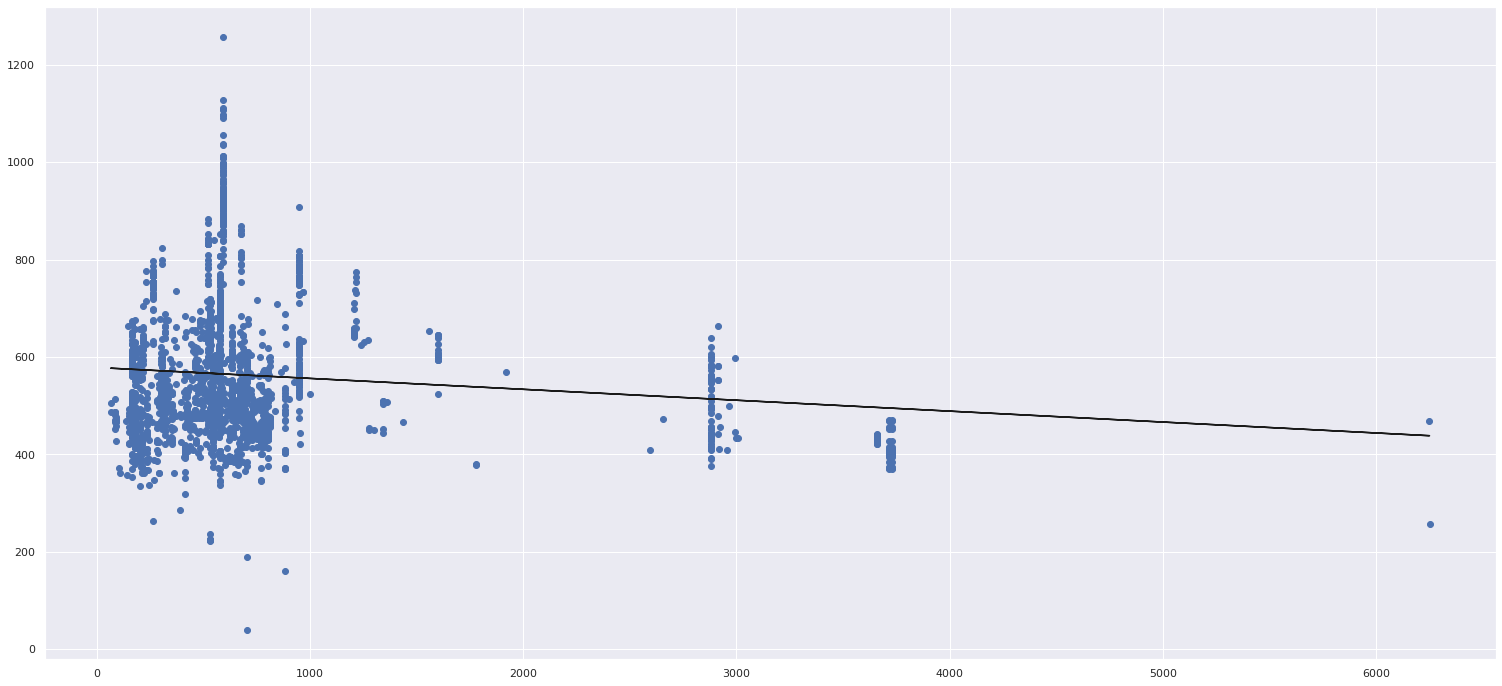

In [143]:
plt.scatter(x,y)
plt.plot(x, y_pred,color='k') 